In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [27]:
train_dat=pd.read_csv('E:/Ineuron ml/first-pipeline/notebook/dataset/gemstone.csv')
train_dat.head()

,id,carat,cut,color,clarity,depth,table,x,y,z,price
0,0,1.52,Premium,F,VS2,62.2,58.0,7.27,7.33,4.55,13619
1,1,2.03,Very Good,J,SI2,62.0,58.0,8.06,8.12,5.05,13387
2,2,0.70,Ideal,G,VS1,61.2,57.0,5.69,5.73,3.50,2772
3,3,0.32,Ideal,G,VS1,61.6,56.0,4.38,4.41,2.71,666
4,4,1.70,Premium,G,VS2,62.6,59.0,7.65,7.61,4.77,14453


In [3]:
train_dat.shape

(193573, 11)

In [4]:
train_dat.dtypes

id           int64
carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
x          float64
y          float64
z          float64
price        int64
dtype: object

In [5]:
train_dat.isnull().sum()

id         0
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
x          0
y          0
z          0
price      0
dtype: int64

In [6]:
train_dat.corr()

,id,carat,depth,table,x,y,z,price
id,1.000000,-0.000771,0.002647,0.002448,-0.000476,-0.000448,0.000037,-0.001392
carat,-0.000771,1.000000,0.027852,0.225737,0.980563,0.980161,0.974274,0.943396
depth,0.002647,0.027852,1.000000,-0.230631,-0.010762,-0.011653,0.081821,0.001880
table,0.002448,0.225737,-0.230631,1.000000,0.237578,0.233299,0.212208,0.174915
x,-0.000476,0.980563,-0.010762,0.237578,1.000000,0.999109,0.989724,0.901004
y,-0.000448,0.980161,-0.011653,0.233299,0.999109,1.000000,0.989527,0.901033
z,0.000037,0.974274,0.081821,0.212208,0.989724,0.989527,1.000000,0.893037
price,-0.001392,0.943396,0.001880,0.174915,0.901004,0.901033,0.893037,1.000000


<AxesSubplot:>

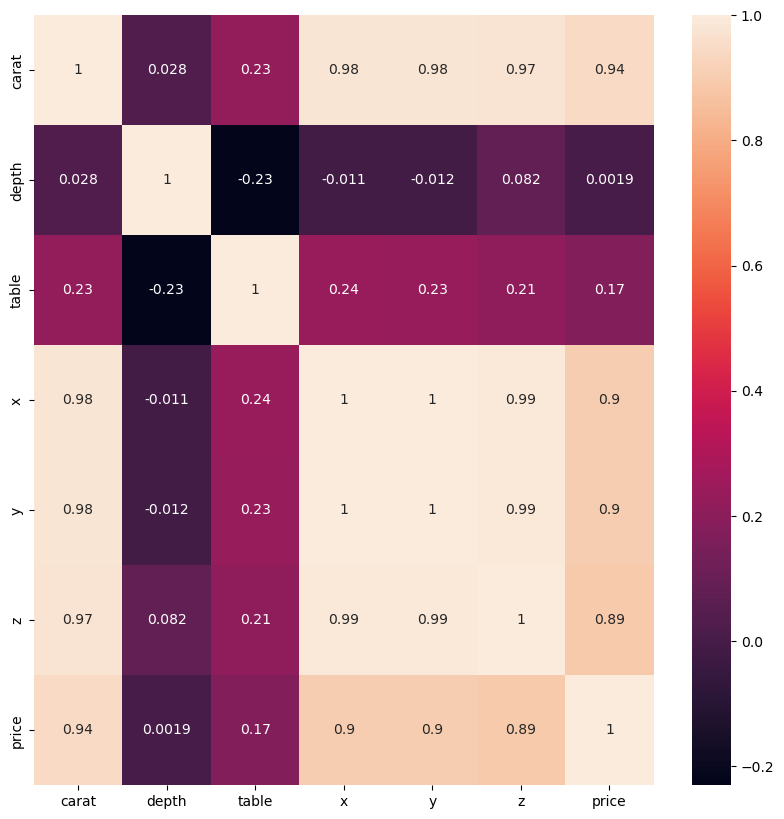

In [38]:
plt.figure(figsize=(10,10))
sns.heatmap(data=train_dat.corr(),annot=True)

Carat column has a high correlation with x,y,z. Depth column is not much correlated with the output feature price. Hence we can drop x,y,z,depth columns from our dataset.

In [28]:
dropped_cols=['x','y','z','depth','id']

In [29]:
train_dat.drop(dropped_cols,axis=1,inplace=True)

In [46]:
numerical_cols=train_dat.select_dtypes(exclude='object').columns.to_list()
categorical_cols=train_dat.select_dtypes(include='object').columns.to_list()
target_col='price'
numerical_cols.remove(target_col)

In [47]:
features_dict={
    'dropped_cols':dropped_cols,
    'numerical_cols':numerical_cols,
    'categorical_cols':categorical_cols,
    'target_col':target_col
}

In [48]:
with open('../src/feature_engineering_artifacts/features_dict.json', 'w') as f:
    json.dump(features_dict, f)

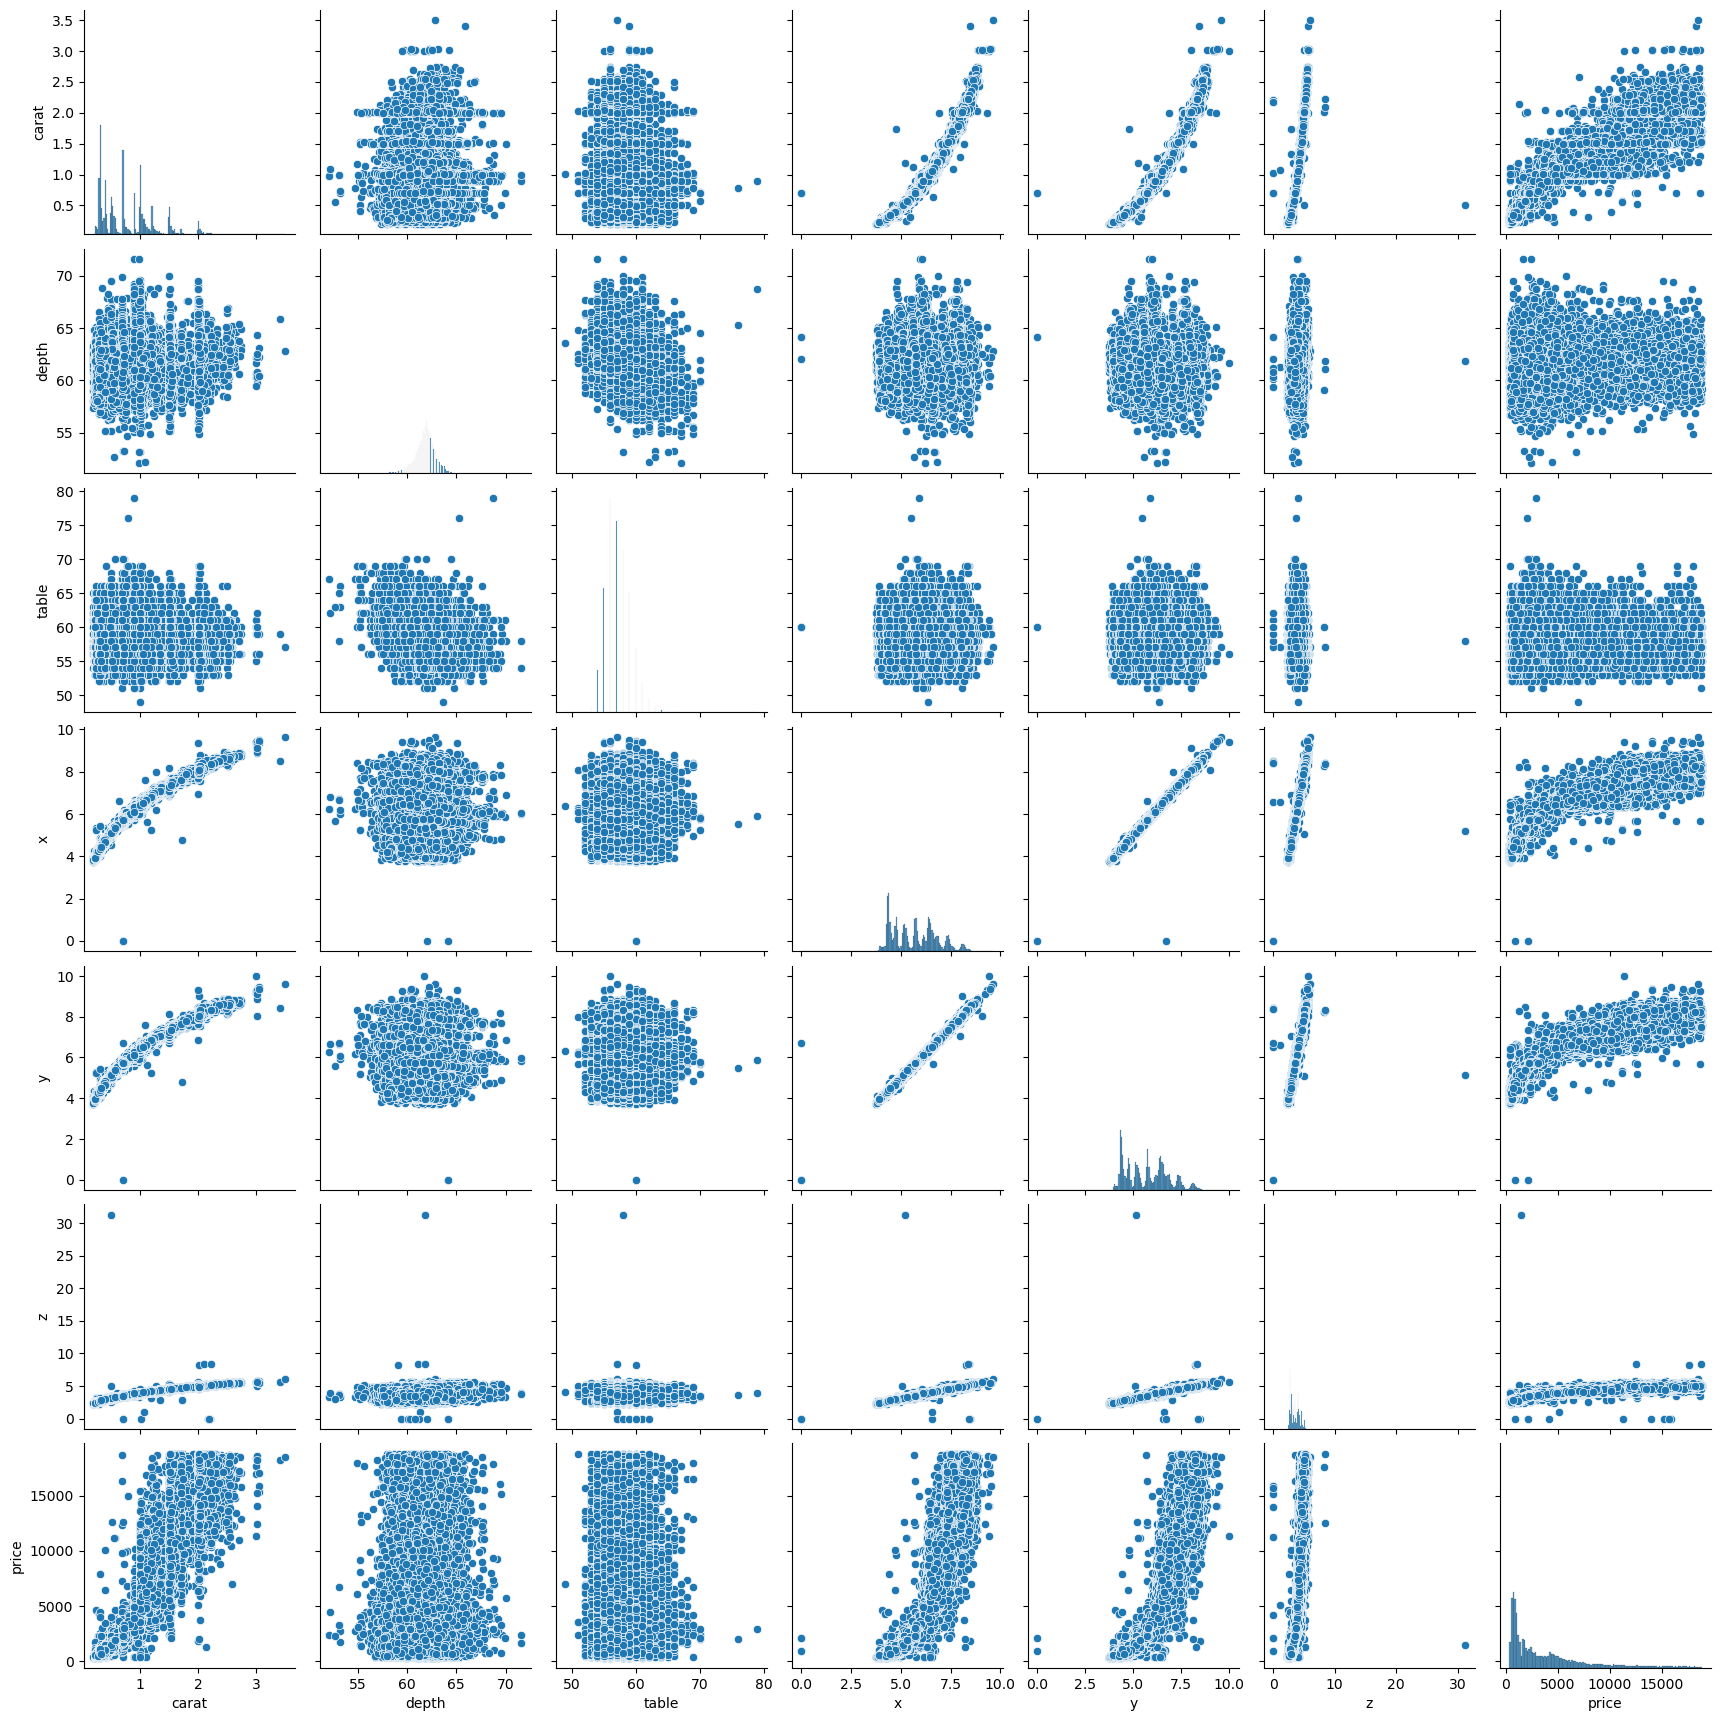

In [39]:
sns.pairplot(data=train_dat)

In [34]:
cat_features=train_dat.columns[train_dat.dtypes==object]
num_features=train_dat.columns[train_dat.dtypes!=object]
print("Categorical features are : ",cat_features)
print("Numerical features are : ",num_features)

Categorical features are :  Index(['cut', 'color', 'clarity'], dtype='object')
Numerical features are :  Index(['carat', 'table', 'price'], dtype='object')


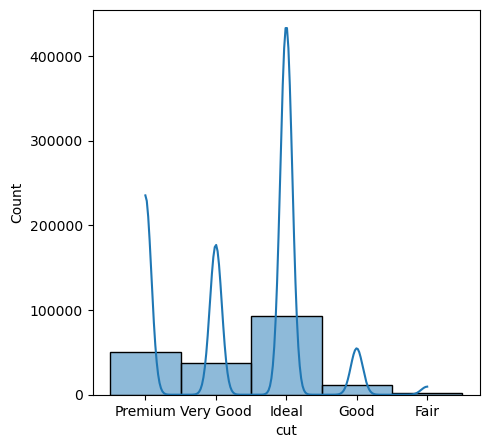

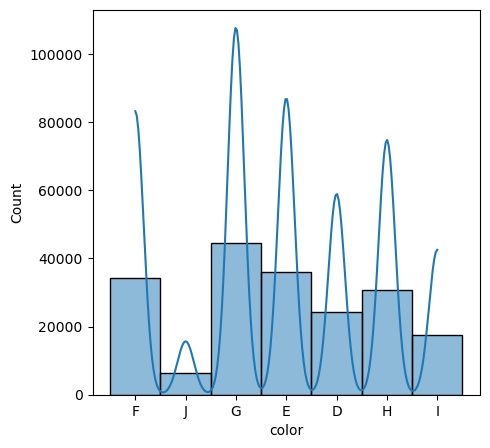

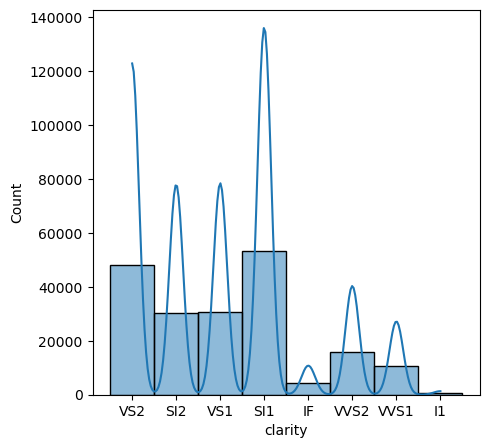

In [41]:
for i in cat_features:
    plt.figure(figsize=(5,5))
    sns.histplot(data=train_dat,x=i,kde=True)

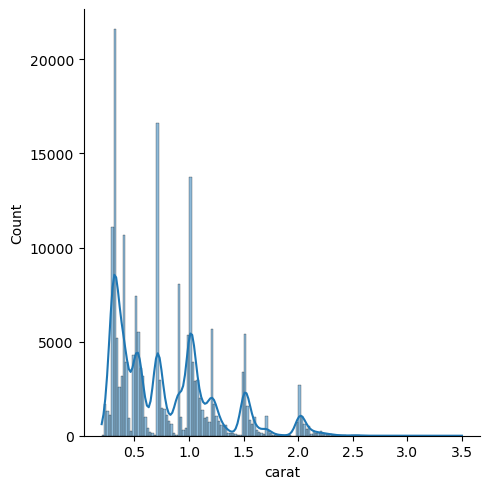

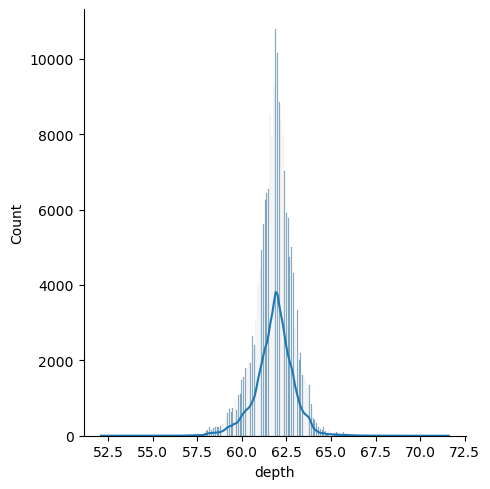

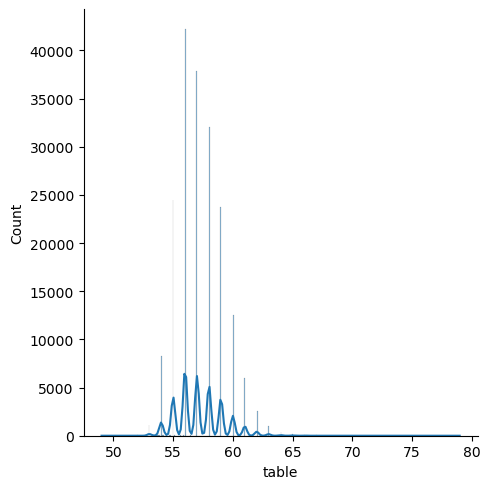

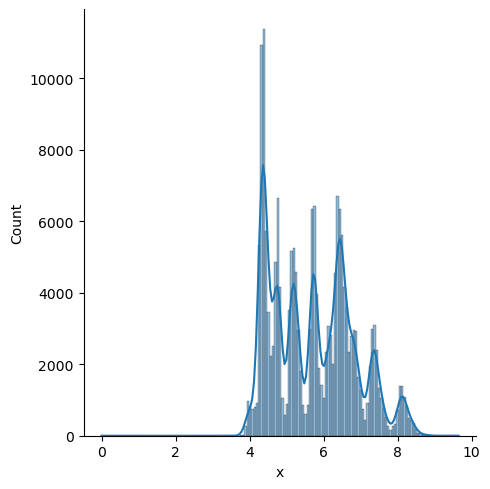

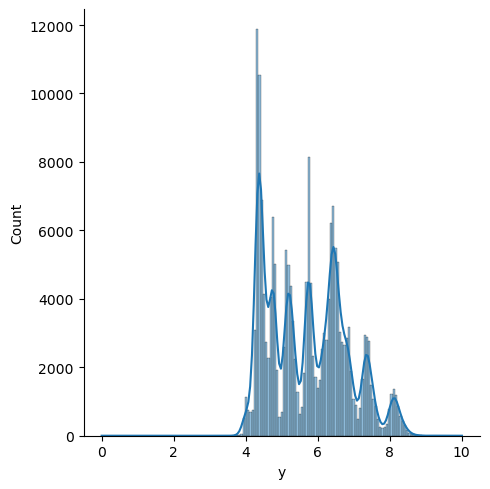

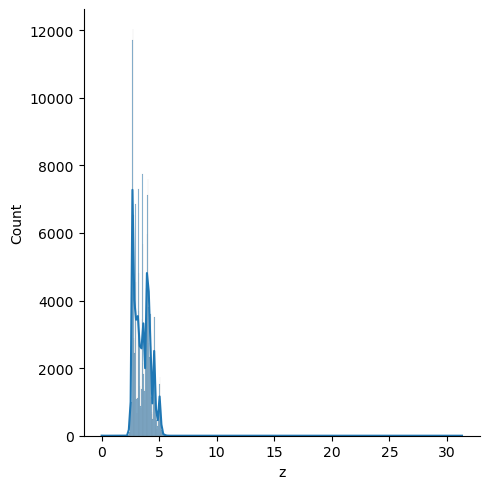

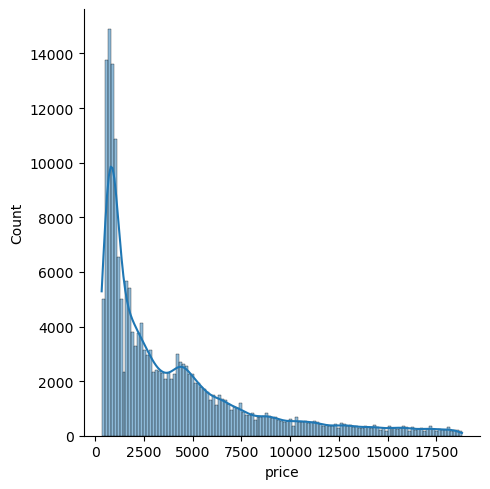

In [42]:
for i in num_features:
    sns.displot(data=train_dat[i],kde=True)

In [35]:
#Categorical Feature Encoding
# Define the custom ranking for each ordinal variable
cut_categories = ['Fair', 'Good', 'Very Good','Premium','Ideal']
color_categories = ['D', 'E', 'F', 'G', 'H', 'I', 'J']
clarity_categories = ['I1','SI2','SI1','VS2','VS1','VVS2','VVS1','IF']

In [23]:
cat_feaures_encoding_order={
    'cut':cut_categories,
    'color':color_categories,
    'clarity':clarity_categories
}

In [26]:
with open('../src/feature_engineering_artifacts/encoding.json','w') as f:
    json.dump(cat_feaures_encoding_order,f)

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,ElasticNet,Ridge,Lasso
from sklearn.preprocessing import StandardScaler,OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [37]:
X=train_dat.drop('price',axis=1)
y=train_dat[['price']]

In [38]:
categorical_cols = X.select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(exclude='object').columns

In [39]:
num_pipeline=Pipeline(
    steps=[
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler',StandardScaler())
    ]
)
cat_pipeline=Pipeline(
    steps=[
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('ordinal_encoder',OrdinalEncoder(categories=[cut_categories,color_categories,clarity_categories])),
    ('scaler',StandardScaler())
    ]
)

In [40]:
preprocessor=ColumnTransformer([
    ('num_pipeline',num_pipeline,numerical_cols),
    ('cat_pipeline',cat_pipeline,categorical_cols)
],verbose_feature_names_out=True)

In [41]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

In [42]:
X_train=pd.DataFrame(preprocessor.fit_transform(X_train),columns=preprocessor.feature_names_in_)
X_test=pd.DataFrame(preprocessor.transform(X_test),columns=preprocessor.feature_names_in_)

In [43]:
X_train.head()

,carat,cut,color,clarity,table
0,-0.823144,-0.641897,0.874100,-0.936747,1.350746
1,0.945023,0.921902,-1.137644,0.910853,0.684455
2,1.958484,0.400636,-0.131772,0.910853,0.018164
3,-0.995648,-0.641897,0.874100,-0.320880,2.017037
4,-0.995648,0.400636,-1.137644,1.526720,-0.648127


In [137]:
X_test.head()

,carat,cut,color,clarity,depth,table,x,y,z
0,-0.629077,0.258230,-0.120630,-0.600482,-0.581521,-0.572248,0.874100,-1.552614,-0.648127
1,2.605374,-2.148014,-0.120630,2.126042,2.198832,1.959219,-1.137644,0.294987,-1.314417
2,-1.125026,-1.222536,0.921902,-1.374347,-1.414721,-1.469110,-0.131772,-0.936747,2.017037
3,-1.017211,-0.574701,0.921902,-1.158385,-1.161138,-1.194265,-0.131772,1.526720,2.017037
4,0.858771,0.628421,-0.641897,0.947248,0.985258,1.004495,0.874100,0.910853,-0.648127


In [138]:
models={'LinearRegression':LinearRegression(),"Ridge":Ridge(),'Lasso':Lasso(),'ElasticNet':ElasticNet()}

In [140]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

In [141]:
def evaluate_model(true,pred):
    mae=mean_absolute_error(true,pred)
    mse=mean_squared_error(true,pred)
    rmse=np.sqrt(mse)
    r2_sc=r2_score(true,pred)
    return mae,rmse,r2_sc

In [142]:
r2_dict={}
for i in models:
    model=models[i]
    model.fit(X_train,y_train)
    pred=model.predict(X_test)
    mae,rmse,r2=evaluate_model(y_test,pred)
    r2_dict[i]=r2
    print(i)
    print("Performance of the Model")
    print("Mean absolute error : ",mae)
    print("Root Mean Square error : ",rmse)
    print("R2 Score : ",r2)
    print('*'*35)
    print('\n')

LinearRegression
Performance of the Model
Mean absolute error :  675.0758270067449
Root Mean Square error :  1014.6296630375482
R2 Score :  0.9362906819996045
***********************************


Ridge
Performance of the Model
Mean absolute error :  675.1077629781757
Root Mean Square error :  1014.6343233534346
R2 Score :  0.936290096749164
***********************************


Lasso
Performance of the Model
Mean absolute error :  676.2421173665509
Root Mean Square error :  1014.6591302750638
R2 Score :  0.9362869814082755
***********************************


ElasticNet
Performance of the Model
Mean absolute error :  1060.9432977143008
Root Mean Square error :  1533.3541245902313
R2 Score :  0.8544967219374031
***********************************




In [145]:
r2_dict=sorted(r2_dict.items(),key=lambda x: x[1],reverse=True)
r2_dict

[('LinearRegression', 0.9362906819996045),
 ('Ridge', 0.936290096749164),
 ('Lasso', 0.9362869814082755),
 ('ElasticNet', 0.8544967219374031)]

In [146]:
print("Model with highest r2 score is :{}({})".format(r2_dict[0][0],r2_dict[0][1]))

Model with highest r2 score is :LinearRegression(0.9362906819996045)
